# 프로젝트: SentencePiece 사용하기

## 목차
- 1. 프로젝트 개요
- 2. 데이터셋 소개
    - (1) 데이터 준비와 확인
    - (2) 데이터 전처리
        - 데이터의 중복 제거
        - NaN 결측치 제거
        - 한글, 영어, 공백 제외하고 모두 제거
        - 레이블 분포 확인
    - (3) 문장 corpus 분석
- 3. SentencePiece 설치하기
- 4. SentencePiece 모델 학습
- 5. Tokenizer 함수 작성
- 6. 네이버 영화리뷰 감정 분석 문제에 SentencePiece 적용해 보기
    - (1) 네이버 영화리뷰 감정 분석 코퍼스에 SentencePiece를 적용시킨 모델 학습하기
    - (2) 학습된 모델로 sp_tokenizer() 메소드 구현하기
    - (3) 구현된 토크나이저를 적용하여 네이버 영화리뷰 감정 분석 모델을 재학습하기
    - (4) KoNLPy 형태소 분석기를 사용한 모델과 성능 비교하기
    - (5) SentencePiece 모델의 model_type, vocab_size 등을 변경해 가면서 성능 개선 여부 확인하기
- 평가기준

## 1. 프로젝트 개요

- 한국어 텍스트의 감정분석 진행
- 활용할 데이터셋은 네이버 영화의 댓글을 모아 구성된 [Naver sentiment movie corpus](https://github.com/e9t/nsmc)
- 네이버 영화리뷰 감정 분석 코퍼스에 SentencePiece를 적용시킨 모델 학습하기
- 학습된 모델로 sp_tokenizer() 메소드 구현하기
- 구현된 토크나이저를 적용하여 네이버 영화리뷰 감정 분석 모델을 재학습하기
- KoNLPy 형태소 분석기를 사용한 모델과 성능 비교하기
- SentencePiece 모델의 model_type, vocab_size 등을 변경해 가면서 성능 개선 여부 확인하기

## 2. 데이터셋 소개

- [Naver Movies](https://movie.naver.com/movie/point/af/list.naver)에서 스크랩된 한국어로 작성된 영화 리뷰 데이터셋
- 데이터 세트 구성은 Maas et.al., 2011의 [Large movie review dataset](http://ai.stanford.edu/~amaas/data/sentiment/)에 언급된 방법에 기초하고 있음

### 데이터셋 구성
- 각 파일은 3개의 컬럼(id, document, label)으로 구성되어 있음
    - id: 리뷰를 작성한 id(네이버에 의해 제공됨)
    - document: 작성된 영화 리뷰
    - label: 리뷰가 속한 sentiment 클래스(0: 부정, 1: 긍정)
    - 컬럼은 'tab'으로 구분되어 있음(tsv 파일 형식. 그러나, 파일 확장명은 .txt이므로 초보자들도 쉽게 다룰 수 있음)
- 총 20만건의 영화 리뷰
    - ratings.txt: 전체 20만 개의 리뷰
    - ratings_test.txt: test에 사용할 50,000개의 리뷰
    - ratings_train.txt: train에 사용할 15만 개의 리뷰

### 데이터셋 특징
- 모든 리뷰가 140자 미만으로 작성되어 있음
- 각 sentimenet class가 동일하게 표본 추출됨(즉, 랜덤 추출은 50% 정확도를 산출함)
- 10만 개의 부정적 입장의 리뷰(1점-4점에 해당하는 리뷰)
- 10만 개의 긍정적 입장의 리뷰(9점-10점에 해당하는 리뷰)
- 중립적 입장의 리뷰(5점-8점에 해당하는 리뷰)는 제외됨

### 예시
![예시.png](./images/예시.png)

### (1) 데이터 준비와 확인

In [1]:
import pandas as pd
import urllib.request
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [2]:
print('학습데이터 문장의 갯수 : ',len(train_data['document']))
print('테스트데이터 문장의 갯수 : ',len(test_data['document']))

학습데이터 문장의 갯수 :  150000
테스트데이터 문장의 갯수 :  50000


#### 데이터의 중복 제거

In [3]:
train_data.drop_duplicates(subset = ['document'], inplace = True)
test_data.drop_duplicates(subset = ['document'], inplace = True)

print('중복제거 후 학습데이터 문장 개수:', len(train_data['document']))
print('중복제거 후 테스트데이터 문장 개수:', len(test_data['document']))

중복제거 후 학습데이터 문장 개수: 146183
중복제거 후 테스트데이터 문장 개수: 49158


#### NaN 결측치 제거

In [4]:
train_data = train_data.dropna(how = 'any')
test_data = test_data.dropna(how = 'any')

print('결측치 제거 후 학습데이터 문장 개수:', len(train_data['document']))
print('결측치 제거 후 테스트데이터 문장 개수:', len(test_data['document']))

결측치 제거 후 학습데이터 문장 개수: 146182
결측치 제거 후 테스트데이터 문장 개수: 49157


#### 한글, 영어 공백 제외하고 모두 제거

In [5]:
train_data[train_data['id'] == 3819312]['document']

1    흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
Name: document, dtype: object

In [6]:
# 한글, 영문, 공벡 제외한 나머지 문자 공백으로 치환
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣A-Za-z ]"," ")
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣A-Za-z ]"," ")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
train_data[train_data['id'] == 3819312]['document']

1    흠   포스터보고 초딩영화줄    오버연기조차 가볍지 않구나
Name: document, dtype: object

In [8]:
# 다중 공백 제거
train_data['document'] = train_data['document'].str.replace(' +', ' ')
test_data['document'] = test_data['document'].str.replace(' +', ' ')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
train_data[train_data['id'] == 3819312]['document']

1    흠 포스터보고 초딩영화줄 오버연기조차 가볍지 않구나
Name: document, dtype: object

In [10]:
# 중복 제거
train_data.drop_duplicates('document', inplace = True)
test_data.drop_duplicates('document', inplace = True)

print("전처리 완료한 학습데이터 문장 개수:", len(train_data['document']))
print("전처리 완료한 테스트데이터 문장 개수:", len(test_data['document']))

전처리 완료한 학습데이터 문장 개수: 144871
전처리 완료한 테스트데이터 문장 개수: 48792


#### 레이블 분포 확인

In [11]:
train_data.groupby('label').size()

label
0    72702
1    72169
dtype: int64

### (3) 문장 corpus 분석
- 다운로드한 데이터가 어떻게 생겼는지 확인해보기<br>
- 문장은 위에서 확인한 것처럼 '144871'개가 포함되어 있음<br>
- 각 문장이 어느 정도의 길이를 가지는지 확인해보기<br>
- 이 과정을 거치면 지나치게 긴 데이터를 삭제하거나(*연산량을 감소시켜 학습 속도가 빨라짐)*
- 지나치게 짧은 데이터를 검증(*무조건 필요가 없지는 않음. '단어 <-> 단어'라면 번역을 학습할 수 있음)*
- 즉, **데이터를 얼마나 사용할지 타협점을 정의**할 수 있음
<br>

- 아래 소스는 문장의 최단 길이, 최장 길이, 평균 길이를 구한 후 문장 길이 분포를 막대그래프로 표현해 주는 소스

문장의 최단 길이: 1
문장의 최장 길이: 140
문장의 평균 길이: 34


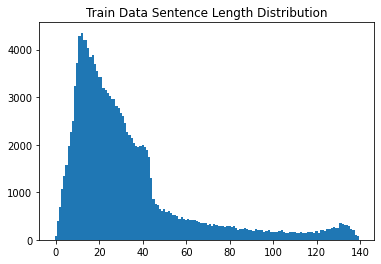

In [12]:
min_len = 999
max_len = 0
sum_len = 0

for sen in train_data['document']:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(train_data['document']))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in train_data['document']:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Train Data Sentence Length Distribution")
plt.show()

- 최단 길이 1, 최장 길이 140의 막대그래프가 나왔음
- 이 결과를 확인하고 아래와 같은 생각이 들 수 있음
    - 1) 길이 1짜리 문장은 어떻게 생긴 문장인가
    - 2) 그래프의 앞부분에서 치솟는 임의의 군간은 무엇인지, 유의미한 데이터가 담겨 있는 부분인가
    - 3) 어디서부터 어디까지 잘라서 사용하는가

In [13]:
# 길이가 1짜리 문장 확인
def check_sentence_with_length(raw, length):
    count = 0
    
    for sen in train_data['document']:
        if len(sen) == length:
            print(sen)
            count += 1
            if count > 100:return 
check_sentence_with_length(train_data['document'], 1)

아
잼
 
굿
짱
휴
음
ㅎ
ㅋ
즐
굳
네
ㅇ
k
ㅠ
쒯
토
O
똥
z
헐
삼
꽝
풉
ㅅ
왜
ㄴ
쉣
봐
뿌
ㅜ
ㅁ
ㅉ
d
흥
찜
귯
린
시
ㅗ
a
c
흠
웅
ㅣ
오
쩜
애
헝
쨩
f
움
ㄳ
업
헉
군
b
g
올
걍
허
쀍
로
ㄹ
ㅂ
갑
즛
킥
함
진
ㅡ
잠
곧
ㅍ
h
캬
ㅆ
풋
ㄱ
파
ㄷ
웩
꺅
욜
ㅄ
핡


- 길이가 1인 문장을 조회해보니 노이즈인 데이터가 많아 제외

In [14]:
cleaned_corpus = []
for sen in train_data['document']:
    cleaned_corpus.append(sen)

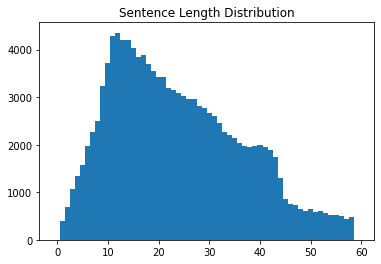

In [15]:
min_len = 2
max_len = 60

# 길이 조건에 맞는 문장만 선택
filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]

# 분포도 다시 그리기
sentence_length = np.zeros((max_len), dtype = np.int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1
    
plt.bar(range(max_len), sentence_length, width = 1.0)
plt.title("Sentence Length Distribution")
plt.show()

## 2. SentencePiece 설치하기

- SentencePiece는 Google에서 제공하는 오픈소스 기반 Sentence Tokenize/Detokenizer
- BPE와 unigram 2가지 subword 토크나이징 모델 중 하나를 선택해서 사용할 수 있도록 패키징한 것
- 아래 링크의 페이지에서 상세한 내용을 파악할 수 있음
- [google/sentence.piece](https://github.com/google/sentencepiece)
<br>

- 위 페이지의 서두에서도 언급하고 있듯, SentencePiece는 딥러닝 자연어처리 모델의 앞부분에 사용할 목적으로 최적화되어 있음
- 최근 pretrained model들이 거의 대부분 SentencePiece를 tokenizer로 채용하면서 사실상 표준의 역할을 하고 있음
- 앞으로의 실습 과정에서 자주 만나게 될 것이므로 친숙해지기
<br>

- 다음과 같이 설치 진행
- SentencePiece는 python에서쓰라고 만들어진 라이브러리는 아니지만 편리한 파이썬 wrapper를 아래와 같이 제공하고 있음
```python
$ pip install sentencepiece
```

## 5. 네이버 영화리뷰 감정 분석 문제에 SentencePiece 적용해 보기

- [네이버 영화리뷰 감정 분석 태스크](https://github.com/e9t/nsmc/)에 SentencePiece 적용해 보기
- 한국어로 된 corpus를 다루어야 하므로 주로 KoNLPy에서 제공하는 형태소 분석기를 사용하여 텍스트를 전처리해서 RNN 모델을 분류기로 사용했을 것
<br>

- 만약 이 문제에서tokenizer를 SentnecePiece로 바꾸어 다시 풀어본다면 더 성능이 좋아지는지 비교해 보는 것도 흥미로울 것
    - 네이버 영화리뷰 감정 분석 코퍼스에 SentencePiece를 적용시킨 모델 학습하기
    - 학습된 모델로 sp_tokenizer() 메소드 구현하기
    - 구현된 토크나이저를 적용하여 네이버 영화리뷰 감정 분석 모델을 재학습하기
    - KoNLPy 형태소 분석기를 사용한 모델과 성능 비교하기
    - (보너스) SentencePiece 모델의 model_type, vocab_size 등을 변경해 가면서 성능 개선 여부 확인하기
    
<br>

- Word Vector는 활용할 필요가 없음(활용이 가능하지도 않을 것)
- 머지않아 SentencePiece와 BERT 등의 pretrained 모델을 함께 활용하는 태스크 다루게 될 것

### (1) 네이버 영화리뷰 감정 분석 코퍼스에 SentencePiece를 적용시킨 모델 학습하기

- 앞서 배운 'tokenize()' 함수
```python
# corpus:  Tokenized Sentence's List
def(tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters = '')
    tokenizer.fit_on_texts(corpus)
    
    tensor = tokenizer.texts_to_sequences(corpus)
    
    tensor= tf.keras.preprocessing.sequence.pad_sequences(tensor, padding = 'post')
    
    return tensor, tokenizer
```

- 위와 같이 'tf.keras.preprocessing.text.Tokenizer'에 corpus를 주고 'tokenizer.fit_on_texts(corpus)'을 하면 토크나이저 내부적으로 단어사전과 토크나이저 기능을 corpus에 맞춤형으로 자동 생성해 주는 것
<br>

- 이를 위해서 SentencePiece 모델을 학습하는 과정 거쳐야 함

In [16]:
import sentencepiece as spm
import os
temp_file = os.getenv('HOME') + '/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    # 이전 스텝에서 정제했던 corpus 활용
    for row in filtered_corpus:
        f.write(str(row) + '\n')

# Train에서 --model_type = 'unigram'이 디폴트 적용되어 있음
# --model_type = 'bpe'로 옵션 주어 변경할 수 있음
spm.SentencePieceTrainer.Train(
     '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)   
)

!ls -l korean_spm*

-rw-r--r-- 1 root root 377786 Oct  4 15:20 korean_spm.model
-rw-r--r-- 1 root root 147213 Oct  4 15:20 korean_spm.vocab


### (2) 학습된 모델로 sp_tokenizer() 메소드 구현하기

- 위에서 훈련시킨 SentencePiece를 활용하여 위 함수와 유사한 기능을 하는 'sp_tokenize()' 함수 정의할 것
- 하지만 SentencePiece가 동작하는 방식이 단순 토큰화와는 달라 완전히 동일하게는 정의하기 어려움
- 그러니 아래 조건을 만족하는 함수를 정의하기
> 1) 매개변수로 토큰화된 문장의 'list'를 전달하는 대신 **온전한 문장**의 'list'를 전달<br>
> 2) **생성된 vocab 파일**을 읽어와 '{ \<word\> : \<idx\> }' 형태를 가지는 'word_index' 사전과 '{\<idx\> : \<word\>'} 형태를 가자ㅣ는 'index_word' 사전을 생성하고 함께 **반환**<br>
> 3) 리턴값인 'tensor'는 앞의 함수와 동일하게 토큰화한 후 Encoding된 문장, 바로 학습에 사용할 수 있게 Padding

In [17]:
s = spm.SentencePieceProcessor()
print(s.Load('korean_spm.model'))

True


In [18]:
def sp_tokenize(s, corpus):

    tensor = []

    for sen in corpus:
#         print(sen)
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, word_index, index_word

In [19]:
#sp_tokenize(s, corpus) 사용예제

my_corpus = ['나는 밥을 먹었습니다.', '그러나 여전히 ㅠㅠ 배가 고픕니다...']
tensor, word_index, index_word = sp_tokenize(s, my_corpus)
print(tensor)

[[ 458 2779   11  849 2090    0    0    0    0    0    0]
 [1144    3 1945  137  427    7    3   12 7575 1036    0]]


### (3) 구현된 토크나이저를 적용하여 네이버 영화리뷰 감정 분석 모델을 재학습하기

In [20]:
X_train = train_data['document']
X_test = test_data['document']

In [21]:
y_train = train_data['label']
y_test = test_data['label']

In [22]:
X_train_tensor, X_train_word_to_index, X_train_index_to_word = sp_tokenize(s,X_train)
X_test_tensor, X_test_word_to_index, X_test_index_to_word = sp_tokenize(s,X_train)

In [23]:
# validation set 28000건 분리(전체 data의 약 20%)
X_val = X_train_tensor[:28000]   
y_val = y_train[:28000]

# validation set을 제외한 나머지 116871건
partial_X_train = X_train_tensor[28000:]  
partial_y_train = y_train[28000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(116871, 133)
(116871,)


In [24]:
vocab_size = 8000
word_vector_dim = 16

In [25]:
model = keras.Sequential(name="LSTM")
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(32, return_sequences = True))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.LSTM(32, return_sequences = True))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          128000    
_________________________________________________________________
lstm (LSTM)                  (None, None, 32)          6272      
_________________________________________________________________
dropout (Dropout)            (None, None, 32)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 32)          8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 32)          0         
_________________________________________________________________
dense (Dense)                (None, None, 1)           33        
Total params: 142,625
Trainable params: 142,625
Non-trainable params: 0
________________________________________________________

In [26]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=30,
                    batch_size=512,
                    validation_data=(X_val, y_val))

Epoch 1/30
229/229 [==============================] - 16s 51ms/step - loss: 0.6217 - accuracy: 0.6061 - val_loss: 0.3965 - val_accuracy: 0.8241
Epoch 2/30
229/229 [==============================] - 10s 45ms/step - loss: 0.3711 - accuracy: 0.8414 - val_loss: 0.3661 - val_accuracy: 0.8392
Epoch 3/30
229/229 [==============================] - 10s 45ms/step - loss: 0.3459 - accuracy: 0.8529 - val_loss: 0.3621 - val_accuracy: 0.8381
Epoch 4/30
229/229 [==============================] - 10s 45ms/step - loss: 0.3308 - accuracy: 0.8582 - val_loss: 0.3565 - val_accuracy: 0.8400
Epoch 5/30
229/229 [==============================] - 10s 45ms/step - loss: 0.3185 - accuracy: 0.8604 - val_loss: 0.3585 - val_accuracy: 0.8395
Epoch 6/30
229/229 [==============================] - 10s 45ms/step - loss: 0.3078 - accuracy: 0.8638 - val_loss: 0.3711 - val_accuracy: 0.8387
Epoch 7/30
229/229 [==============================] - 10s 45ms/step - loss: 0.3021 - accuracy: 0.8632 - val_loss: 0.3666 - val_accuracy:

In [27]:
history_dict = history.history

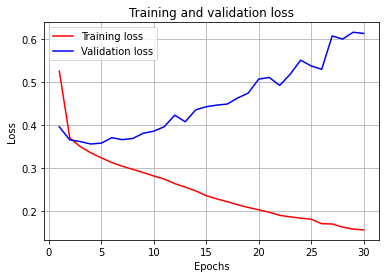

In [28]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# 빨간 실선으로 표시
plt.plot(epochs, loss, 'r', label='Training loss')
# 파란 실선으로 표시
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()

plt.show()

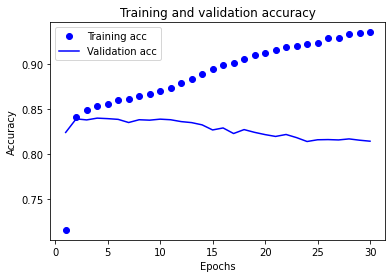

In [29]:
# 그림 초기화
plt.clf() 

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title("Training and validation accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [31]:
import sentencepiece as spm
import os
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm_bpe --vocab_size={}'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm_bpe*

-rw-r--r-- 1 root root 377790 Oct  4 15:38 korean_spm_bpe.model
-rw-r--r-- 1 root root 147213 Oct  4 15:38 korean_spm_bpe.vocab


In [32]:
s = spm.SentencePieceProcessor()
print(s.Load('korean_spm_bpe.model'))

True


In [33]:
def sp_tokenize_bpe(s, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm_bpe.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, word_index, index_word

In [34]:
X_train_tensor_bpe, X_train_word_to_index_bpe, X_train_index_to_word_bpe = sp_tokenize_bpe(s,X_train)
X_test_tensor_bpe, X_test_word_to_index_bpe, X_test_index_to_word_bpe = sp_tokenize_bpe(s,X_train)

In [35]:
# validation set 28000건 분리(전체 data의 약 20%)
X_val_bpe = X_train_tensor_bpe[:28000]   
y_val_bpe = y_train[:28000]

# validation set을 제외한 나머지 116871건
partial_X_train_bpe = X_train_tensor_bpe[28000:]  
partial_y_train_bpe = y_train[28000:]

print(partial_X_train_bpe.shape)
print(partial_y_train_bpe.shape)

(116871, 133)
(116871,)


In [36]:
model1 = keras.Sequential(name="LSTM")
model1.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model1.add(keras.layers.LSTM(32, return_sequences = True))
model1.add(keras.layers.Dropout(0.3))
model1.add(keras.layers.LSTM(32, return_sequences = True))
model1.add(keras.layers.Dropout(0.3))
model1.add(keras.layers.Dense(1, activation='sigmoid'))

model1.summary()

Model: "LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          128000    
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 32)          6272      
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 32)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 32)          8320      
_________________________________________________________________
dropout_3 (Dropout)          (None, None, 32)          0         
_________________________________________________________________
dense_1 (Dense)              (None, None, 1)           33        
Total params: 142,625
Trainable params: 142,625
Non-trainable params: 0
________________________________________________________

In [37]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(partial_X_train_bpe,
                    partial_y_train_bpe,
                    epochs=30,
                    batch_size=512,
                    validation_data=(X_val_bpe, y_val_bpe))

Epoch 1/30
229/229 [==============================] - 14s 49ms/step - loss: 0.1519 - accuracy: 0.9382 - val_loss: 0.5712 - val_accuracy: 0.8140
Epoch 2/30
229/229 [==============================] - 10s 44ms/step - loss: 0.1415 - accuracy: 0.9437 - val_loss: 0.6478 - val_accuracy: 0.8134
Epoch 3/30
229/229 [==============================] - 10s 44ms/step - loss: 0.1341 - accuracy: 0.9468 - val_loss: 0.6538 - val_accuracy: 0.8114
Epoch 4/30
229/229 [==============================] - 10s 44ms/step - loss: 0.1339 - accuracy: 0.9460 - val_loss: 0.6421 - val_accuracy: 0.8098
Epoch 5/30
229/229 [==============================] - 10s 45ms/step - loss: 0.1307 - accuracy: 0.9477 - val_loss: 0.6421 - val_accuracy: 0.8107
Epoch 6/30
229/229 [==============================] - 10s 44ms/step - loss: 0.1241 - accuracy: 0.9508 - val_loss: 0.7104 - val_accuracy: 0.8147
Epoch 7/30
229/229 [==============================] - 10s 45ms/step - loss: 0.1306 - accuracy: 0.9489 - val_loss: 0.6727 - val_accuracy:

In [38]:
history_dict = history.history

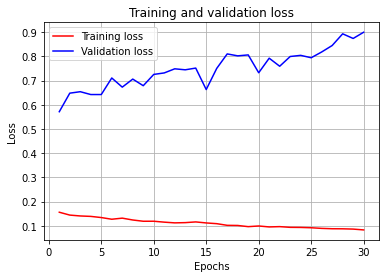

In [39]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# 빨간 실선으로 표시
plt.plot(epochs, loss, 'r', label='Training loss')
# 파란 실선으로 표시
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()

plt.show()

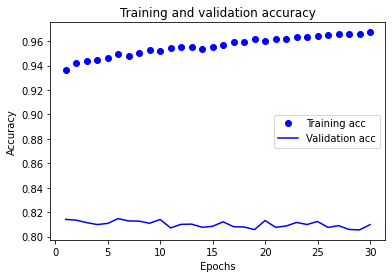

In [40]:
# 그림 초기화
plt.clf() 

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title("Training and validation accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### (4) KoNLPy 형태소 분석기를 사용한 모델과 성능 비교하기

In [41]:
from konlpy.tag import Mecab

In [42]:
mecab = Mecab()

In [43]:
def mecab_split(sentence):
    return mecab.morphs(sentence)

mecab_corpus = []

for kor in train_data['document']:
    mecab_corpus.append(mecab_split(kor))

In [44]:
mecab_corpus[:4]

[['아', '더', '빙', '진짜', '짜증', '나', '네요', '목소리'],
 ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍', '지', '않', '구나'],
 ['너무', '재', '밓었다그래서보는것을추천한다'],
 ['교도소', '이야기', '구먼', '솔직히', '재미', '는', '없', '다', '평점', '조정']]

In [45]:
mecab_train_len_list = [len(token) for token in mecab_corpus]
mecab_test_len_list = [len(token) for token in X_test]
mecab_num_tokens = mecab_train_len_list + mecab_test_len_list
print(len(mecab_num_tokens))

193663


In [46]:
print('문장 길이 평균 : ', np.mean(mecab_num_tokens))
print('문장 길이 최대 : ', np.max(mecab_num_tokens))
print('문장 길이 최소 : ', np.min(mecab_num_tokens))
print('문장 길이 표준편차 : ', np.std(mecab_num_tokens))

문장 길이 평균 :  21.101294516763655
문장 길이 최대 :  140
문장 길이 최소 :  0
문장 길이 표준편차 :  20.19083550414943


In [47]:
mecab_max_tokens = np.mean(mecab_num_tokens) + 70
mecab_maxlen = int(mecab_max_tokens)
print('pad_sequences maxlen : ', mecab_maxlen)
# 길이가 111인 문장이 약 25% 정도 되어 따로 삭제하지 않고 그대로 사용
print(f'전체 문장의 {np.sum(mecab_num_tokens < mecab_max_tokens) / len(mecab_num_tokens)*100}%가 maxlen 설정값 이내에 포함됩니다.')

pad_sequences maxlen :  91
전체 문장의 98.34093244450412%가 maxlen 설정값 이내에 포함됩니다.


In [48]:
def tokenize(corpus):  # corpus: Tokenized Sentence's List
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [49]:
# 형태소 기반 토큰화를 진행한 후, 단어 사전의 길이 확인
mecab_tensor, mecab_tokenizer = tokenize(mecab_corpus)
print("MeCab Vocab Size:", len(mecab_tokenizer.index_word))

MeCab Vocab Size: 51210


In [50]:
len(mecab_tensor)

144871

In [51]:
mecab_tensor[0]

array([ 35,  78, 923,  41, 227,  22,  36, 721,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0], dtype=int32)

In [52]:
tmp_x_test = mecab_tokenizer.texts_to_sequences(test_data['document'])
tmp_x_test = tf.keras.preprocessing.sequence.pad_sequences(tmp_x_test, padding='post')

In [53]:
tmp_x_test[0]

array([809, 132,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0], dtype=int32)

In [54]:
mecab_x_train = mecab_tensor
mecab_y_train = np.array(train_data['label'])
mecab_x_test = tmp_x_test
mecab_y_test = np.array(test_data['label'])

In [55]:
print(len(mecab_x_train), len(mecab_y_train))
print(len(mecab_x_test), len(mecab_y_test))

144871 144871
48792 48792


In [56]:
print(type(mecab_x_train), type(mecab_y_train))
print(type(mecab_x_test), type(mecab_y_test))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [57]:
mecab_x_train

array([[   35,    78,   923, ...,     0,     0,     0],
       [ 1006,   500,   513, ...,     0,     0,     0],
       [   26,   204, 29147, ...,     0,     0,     0],
       ...,
       [  152,    90,   194, ...,     0,     0,     0],
       [ 1021,     3,     8, ...,     0,     0,     0],
       [  180,     3,  1890, ...,     0,     0,     0]], dtype=int32)

In [58]:
# check
ch_max = 0
for x in mecab_x_train:
    tmp = max(x)
    if tmp > ch_max:
        ch_max = tmp
print(ch_max)

51210


In [59]:
# 모델 생성
word_vector_dim = 16

model2 = keras.Sequential()
model2.add(keras.layers.Embedding(ch_max+1, word_vector_dim, input_shape=(None,)))
model2.add(keras.layers.LSTM(8))
model2.add(keras.layers.Dense(8, activation='relu'))
model2.add(keras.layers.Dense(1, activation='sigmoid'))

model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          819376    
_________________________________________________________________
lstm_4 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 820,257
Trainable params: 820,257
Non-trainable params: 0
_________________________________________________________________


In [60]:
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_mecab = model2.fit(mecab_x_train, mecab_y_train, epochs=20, batch_size=512, validation_split=0.2, verbose=1)

Epoch 1/20
227/227 [==============================] - 7s 23ms/step - loss: 0.6932 - accuracy: 0.5022 - val_loss: 0.6931 - val_accuracy: 0.5040
Epoch 2/20
227/227 [==============================] - 5s 21ms/step - loss: 0.6932 - accuracy: 0.4995 - val_loss: 0.6931 - val_accuracy: 0.5040
Epoch 3/20
227/227 [==============================] - 5s 21ms/step - loss: 0.6931 - accuracy: 0.5041 - val_loss: 0.6931 - val_accuracy: 0.5040
Epoch 4/20
227/227 [==============================] - 5s 21ms/step - loss: 0.6932 - accuracy: 0.4992 - val_loss: 0.6932 - val_accuracy: 0.4960
Epoch 5/20
227/227 [==============================] - 5s 21ms/step - loss: 0.6932 - accuracy: 0.4971 - val_loss: 0.6931 - val_accuracy: 0.5040
Epoch 6/20
227/227 [==============================] - 5s 21ms/step - loss: 0.6931 - accuracy: 0.4979 - val_loss: 0.6931 - val_accuracy: 0.5040
Epoch 7/20
227/227 [==============================] - 5s 21ms/step - loss: 0.6931 - accuracy: 0.5021 - val_loss: 0.6931 - val_accuracy: 0.5040

In [61]:
results_mecab = model2.evaluate(mecab_x_test,  mecab_y_test, verbose=2)

1525/1525 - 5s - loss: 0.6932 - accuracy: 0.4975


## 평가기준
- 아래의 기준을 바탕으로 평가

|평가문항|상세기준|
|---|---|
|1. SentencePice를 이용하여 모델을 만들기까지의 과정이 정상적으로 진행되었는가?|코퍼스 분석, 전처리, SentencePiece 적용, 토크나이저 구현 및 동작이 빠짐없이 진행되었는가|
|2. SentencePiece를 통해 만든 Tokenizer가 자연어처리 모델과 결합하여 동작하는가?|SentencePiece 토크나이저가 적용된 Text Classifier 모델이 정상적으로 수렴하여 80% 이상의 test accuracy가 확인되었는가|
|3. SentencePiece의 성능을 다각도로 비교분석하였는가?|SentencePiece 토크나이저를 활용했을 때의 성능을 다른 토크나이저 혹은 SentencePiece의 다른 옵션의 경우와 비교하여 분석을 체계적으로 진행하였는가|